In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-spoiler-dataset/IMDB_movie_details.json
/kaggle/input/imdb-spoiler-dataset/IMDB_reviews.json


# Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
###
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB
####
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#####
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# Creation of confusion matrix in using sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix


## **Data Extraction and Preprocessing**

In [3]:
df_reviews = pd.read_json('../input/imdb-spoiler-dataset/IMDB_reviews.json', lines=True)
df_details = pd.read_json('../input/imdb-spoiler-dataset/IMDB_movie_details.json',lines =True)

In [4]:
print(df_reviews.shape)
print(df_details.shape)

(573913, 7)
(1572, 7)


In [5]:
df_reviews.head()                                                                                                                                                                                                                                                                                                                            

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


In [6]:
df_details.head()

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_spoiler', ylabel='count'>

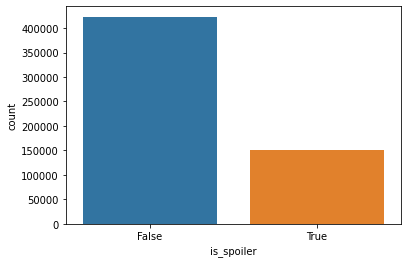

In [7]:
sns.countplot(df_reviews['is_spoiler'])


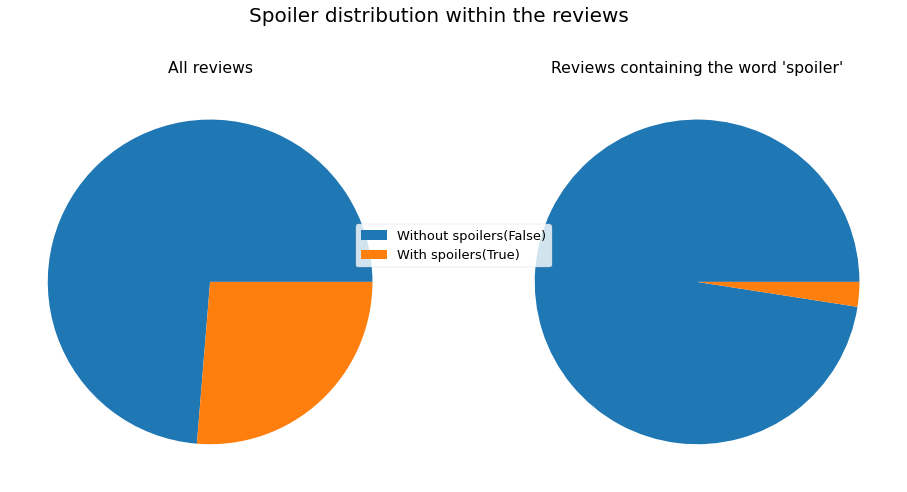

In [8]:
##### Extract the information from the data
spoiler_df = pd.DataFrame()
spoiler_df["is_spoiler"] = df_reviews["is_spoiler"] 
spoiler_df["has_a_word_spoiler"] = df_reviews["review_text"].apply(lambda 
                                                                  text : True if "spoiler" in text 
                                                                  else False)

pie1 = spoiler_df['is_spoiler'].value_counts().reset_index().sort_values(by='index')
pie2 = spoiler_df["has_a_word_spoiler"].value_counts().reset_index().sort_values(by='index')

with plt.style.context('seaborn-talk'):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.pie(pie1['is_spoiler'])
    ax1.set_title('All reviews')

    ax2.pie(pie2['has_a_word_spoiler'])
    ax2.set_title('Reviews containing the word \'spoiler\'')

    plt.suptitle('Spoiler distribution within the reviews', fontsize=20)
    fig.legend(labels=['Without spoilers(False)', 'With spoilers(True)'], loc='center')

    plt.show()

## **Picked a Small Batch of data to choose a best model for classification**

In [9]:
def get_part_data(df, num_reviews):
    
    num_pos_reviews = df[df["is_spoiler"]== True].shape[0]  # Number of spoilers in the dataset
    num_neg_reviews = df[df["is_spoiler"]== False].shape[0] # Number of Non-spoilers in the dataset
    
    fraction_pos = num_reviews/num_pos_reviews  # fraction of spoiler reviews to be returned
    fraction_neg = num_reviews/num_neg_reviews  # fraction of non-spoiler reviews to be returned 

    df_pos = df[df['is_spoiler'] == True].sample(frac = fraction_pos, random_state = 2)
    df_neg = df[df['is_spoiler'] == False].sample(frac = fraction_neg, random_state = 2)

    df_re = pd.concat([df_pos, df_neg])  # join the True and False dataset
    df_re = df_re.reset_index(drop=True)  # mix the index values
    df_re.loc[(df_re['is_spoiler'] == True) ,'is_spoiler'] =1
    df_re.loc[(df_re['is_spoiler'] == False) ,'is_spoiler'] =0
    return df_re[["movie_id","review_text","review_summary","is_spoiler"]]

In [10]:
d = get_part_data(df_reviews, 110000)
d["is_spoiler"] = d["is_spoiler"].astype('int')

df_r = d[["review_text","is_spoiler"]]

In [11]:
d.head()

,movie_id,review_text,review_summary,is_spoiler
0,tt1049413,Overall: This movie is just simply excellent. ...,One of Pixar's Best; My personal favourite,1
1,tt1131734,I decided to watch Jennifer's Body after my fa...,One of the most enjoyable films I have ever w...,1
2,tt0451279,This review focuses on Greek Mythology in the ...,Serious Greek Myth Fail,1
3,tt1723811,I personally do not understand it when people ...,A shameful tragedy!,1
4,tt0464154,"I loved this film, was truly great fun, OK the...",Great Fun,1


## **Pre-process the reviews by removing the stop words, tokenizing and lemmitization**

In [12]:
import spacy
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [13]:
# lower the words in training data
ltexts = [[word.lower() for word in line.split()] for line in df_r["review_text"]]

In [14]:
def preprocess(text):
    text = ' '.join(text)
    # tokenization and removing stop words
    token = [t for t in nlp(text) if not t.is_stop] 
    # lemmatization
    lemma = [lem.lemma_ for lem in token]
    # removing the non-alphabetic words
    return [' '.join(i for i in lemma if i.isalpha()) ]

In [15]:
print(ltexts[5])

# sample preprocessing for one text in the data
print(preprocess(ltexts[5]))

['now', 'i', "haven't", 'read', 'the', 'stephen', 'king', 'novel', 'this', 'movie', 'is', 'based', 'on,', 'or', 'the', 'first', '"carrie"', 'movie.', 'but', 'this', 'one', 'just', 'seemed', 'like', 'it', 'needed', 'more', 'development', 'because', 'the', 'whole', 'thing', 'seemed', 'a', 'bit', 'rushed.', "it's", 'a', 'very', 'predictable', 'movie,', 'even', 'if', 'you', "don't", 'know', 'certain', 'things', 'about', 'this', 'flick', 'before', 'watching.', 'it', 'just', 'seemed', 'kind', 'of', 'forced', 'at', 'times,', 'and', 'when', "it's", 'over', "it's", 'just', 'not', 'really', 'satisfying.', 'chloë', 'grace', 'moretz', 'is', 'a', 'good', 'actress', 'and', 'there', 'is', 'a', 'bright', 'future', 'for', 'her', 'in', 'this', 'industry.', 'but', 'the', 'part', 'where', 'she', 'snaps', "didn't", 'really', 'do', 'it,', 'because', 'her', 'eyes', 'are', 'just', 'too', 'innocent', 'looking', 'even', 'when', 'she', 'tries', 'to', 'act', 'like', 'she', 'is', 'angry.', 'which', 'takes', 'away'

In [16]:
# proc_text = []
# for i in range(len(ltexts)):
#     proc_text.append(preprocess(ltexts[i]))

In [17]:
#proc_text[5]

## **Base line Dummy classifier**

In [18]:
### Base line Dummy classifier
X_train, X_test, y_train, y_test = train_test_split(df_r["review_text"], df_r["is_spoiler"],
                                                     test_size=0.30, random_state=9)
# Dummy classifier model
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
    
# Predict the train by using dummmy classifier
dummy_train_pred = clf.predict(X_train)
dummy_test_pred  = clf.predict(X_test)
    
print(classification_report(y_train, dummy_train_pred))
print(classification_report(y_test,dummy_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     76945
           1       0.50      0.50      0.50     77055

    accuracy                           0.50    154000
   macro avg       0.50      0.50      0.50    154000
weighted avg       0.50      0.50      0.50    154000

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     33055
           1       0.50      0.50      0.50     32945

    accuracy                           0.50     66000
   macro avg       0.50      0.50      0.50     66000
weighted avg       0.50      0.50      0.50     66000



## **Naive Bayes Classifier**

In [19]:
import sklearn.metrics as metrics

In [20]:
is_spoiler = ["True","False"]

### Naive Bayes model to predict the spoilers
def model_pipe(df):
    X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["is_spoiler"],
                                                        test_size=0.30, random_state=9)
    # pipline the process for text classification
    pipe = Pipeline([("count_vectorizer", CountVectorizer(stop_words="english")),
                     ("tfidf_transformer", TfidfTransformer()),
                     ("nb_classifier", BernoulliNB())])

    # fit the model to the train data
    pipe.fit(X_train, y_train)

    # predict the train values
    train_pred = pipe.predict(X_train)

    # predict the test
    test_pred = pipe.predict(X_test)
    
    cm = confusion_matrix(y_test,test_pred)
    fig,ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=is_spoiler)
    disp.plot(ax=ax)
    plt.show()
    
    fpr, tpr, _ = metrics.roc_curve(y_test,  test_pred)
    auc = metrics.roc_auc_score(y_test, test_pred)
    plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

    print(classification_report(y_train, train_pred))
    print(classification_report(y_test, test_pred))
    print("AUC Score")
    print(roc_auc_score(y_test, test_pred))
    
    

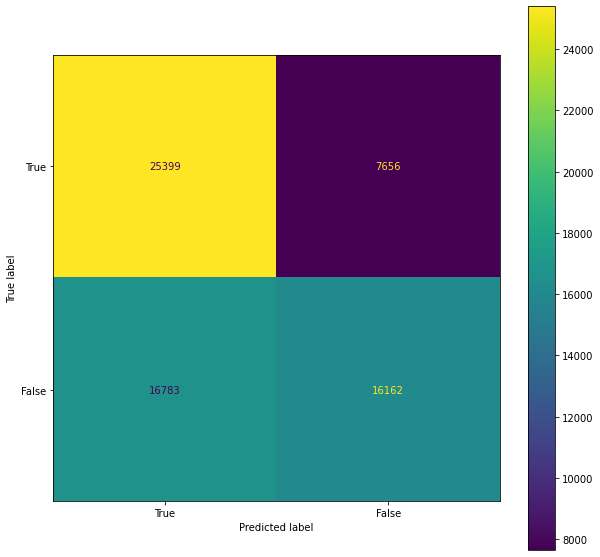

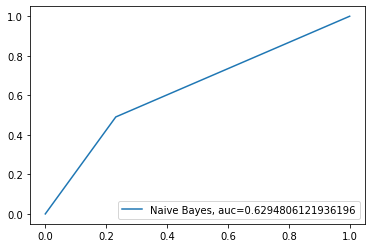

              precision    recall  f1-score   support

           0       0.61      0.78      0.68     76945
           1       0.69      0.50      0.58     77055

    accuracy                           0.64    154000
   macro avg       0.65      0.64      0.63    154000
weighted avg       0.65      0.64      0.63    154000

              precision    recall  f1-score   support

           0       0.60      0.77      0.68     33055
           1       0.68      0.49      0.57     32945

    accuracy                           0.63     66000
   macro avg       0.64      0.63      0.62     66000
weighted avg       0.64      0.63      0.62     66000

AUC Score
0.6294806121936196


In [21]:
model_pipe(df_r)

In [22]:
from sklearn.model_selection import GridSearchCV
Gpipe = Pipeline([('count_vect',CountVectorizer(stop_words="english")),
                ('tfidf_transformer',TfidfTransformer()),
                ('nbClassifier',BernoulliNB())])


parameters = {
    'count_vect__binary': [True, False],
    'count_vect__ngram_range': [(1, 1), (1, 2)],
    'nbClassifier__alpha': (1, 0.1),
}

grid_search = GridSearchCV(Gpipe, parameters, cv=5)

In [23]:
#clf = grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)

In [24]:
#naive_pred = grid_search(X_test)
#print(classification_report(y_test,naive_pred))

## **XG Boost Classifier**

In [25]:
import xgboost as xgb

In [26]:
def xgmodel_pipe(df):
    X_train, X_test, y_train, y_test = train_test_split(df["review_text"], df["is_spoiler"],
                                                        test_size=0.30, random_state=9)
    # pipline the process for text classification
    pipe = Pipeline([("count_vectorizer", CountVectorizer(stop_words = "english")),
                     ("tfidf_transformer", TfidfTransformer()),
                     ("xg_classifier", xgb.XGBClassifier(eta = 0.75, objective="binary:logitraw"))])

    # fit the model to the train data
    pipe.fit(X_train, y_train)

    # predict the train values
    train_pred = pipe.predict(X_train)

    # predict the test
    test_pred = pipe.predict(X_test)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test,test_pred)
    fig,ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=is_spoiler)
    disp.plot(ax=ax)
    plt.show()
    
     
    fpr, tpr, _ = metrics.roc_curve(y_test,  test_pred)
    auc = metrics.roc_auc_score(y_test, test_pred)
    plt.plot(fpr,tpr,label="XGBoost, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
     # Classification report
    print(classification_report(y_train, train_pred))
    print(classification_report(y_test, test_pred))
    print("AUC Score")
    print(roc_auc_score(y_test, test_pred))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:15:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.4.0, the default evaluation metric used with the objective 'binary:logitraw' was changed from 'auc' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


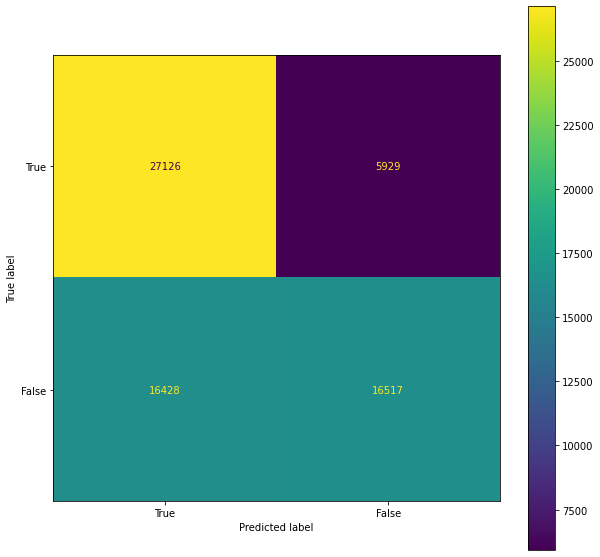

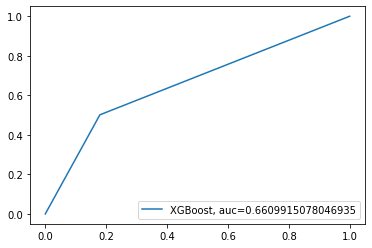

              precision    recall  f1-score   support

           0       0.69      0.91      0.78     76945
           1       0.87      0.60      0.71     77055

    accuracy                           0.75    154000
   macro avg       0.78      0.75      0.75    154000
weighted avg       0.78      0.75      0.75    154000

              precision    recall  f1-score   support

           0       0.62      0.82      0.71     33055
           1       0.74      0.50      0.60     32945

    accuracy                           0.66     66000
   macro avg       0.68      0.66      0.65     66000
weighted avg       0.68      0.66      0.65     66000

AUC Score
0.6609915078046935


In [27]:
xgmodel_pipe(df_r)

## Word2Vec used for word embedding technique

In [28]:
import spacy
from functools import reduce
import gensim
from gensim.models import Word2Vec
nlp = spacy.load('en_core_web_lg')

In [29]:
data_e = get_part_data(df_reviews, 20000)
data_e["is_spoiler"] = data_e["is_spoiler"].astype('int')

To identify the spolier in the review text. I thought, whether the word2vector using word embedding technique may find the cosine similarity between the **Review_text** and the **Plot summary** of the respective movie.

Therefore, I implemented the Cosine similarity function to check the IMDB review text.

In [30]:
# Join the reviews with the plot summary of respective movie in df_details dataset
reframed_data = data_e.merge(df_details, how='left', on='movie_id')
reframed_data.head()

,movie_id,review_text,review_summary,is_spoiler,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt1049413,Overall: This movie is just simply excellent. ...,One of Pixar's Best; My personal favourite,1,Carl Fredricksen as a boy wanted to explore So...,1h 36min,"[Animation, Adventure, Comedy]",8.3,2009-05-29,"Young Carl Fredricksen (Jeremy Leary), a quiet..."
1,tt1131734,I decided to watch Jennifer's Body after my fa...,One of the most enjoyable films I have ever w...,1,"Nerdy, reserved bookworm Needy Lesnicki, and a...",1h 42min,"[Comedy, Horror]",5.1,2009-09-18,Opening scene (depending on the DVD's theatric...
2,tt0451279,This review focuses on Greek Mythology in the ...,Serious Greek Myth Fail,1,"Diana, princess of the Amazons, trained to be ...",2h 21min,"[Action, Adventure, Fantasy]",7.6,2017-06-02,"In the opening scene in modern day Paris, Fran..."
3,tt1723811,I personally do not understand it when people ...,A shameful tragedy!,1,Brandon is a 30-something man living in New Yo...,1h 41min,[Drama],7.2,2012-01-13,"Brandon (Michael Fassbender) is a successful, ..."
4,tt0464154,"I loved this film, was truly great fun, OK the...",Great Fun,1,"Lake Victoria's annual Spring party by 50,000 ...",1h 28min,"[Comedy, Horror, Thriller]",5.5,2010-08-20,Fisherman Matthew Boyd (Richard Dreyfuss) fish...


In [31]:
# train and test spilt for word embedding technique
x_train, x_test, Y_train, Y_test = train_test_split(reframed_data[["review_text","plot_summary"]],reframed_data["is_spoiler"],
                                                    test_size=0.30, random_state=9)

In [32]:
from functools import reduce
def tn(sentence):
    return reduce(lambda x,y: x+y, [nlp.vocab[w].vector for w in sentence.split()])

def transform1(row):
        s1 = tn(row.review_text)
        s2 = tn(row.plot_summary)
        return np.stack([s1,s2])
    
def transform(X):
        return np.concatenate(
            [transform1(row).reshape(1, -1) for row in X.itertuples()]
        )

def cosine_sim(arr1, arr2): 
    ### to predict the spoiler by comparing the review text with orginal plot summary
    return np.dot(arr1, arr2) / (np.linalg.norm(arr1) * np.linalg.norm(arr2))


def transform2(row):
        s1 = tn(row.review_text)
        s2 = tn(row.plot_summary)
        return cosine_sim(s1,s2)
    
    
def similarity_predict(data, threshold):   
    simPred = []
    for row in data.itertuples():
        sim = transform2(row)
        if sim >=threshold:
            simPred.append(int(1))
        else:
            simPred.append(int(0))
    return simPred

In [33]:
# By using the cosine similarity to identify which reviews having the spoiler
a = similarity_predict(x_train,0.9)
b = similarity_predict(x_test,0.9)

sim_train_pred = pd.DataFrame(a)
sim_test_pred  = pd.DataFrame(b)

print(classification_report(sim_train_pred,Y_train))
print(classification_report(sim_test_pred,Y_test))

# print("AUC Score")
# from sklearn.metrics import roc_auc_score
# print(roc_auc_score(Y_test, sim_test_pred))

              precision    recall  f1-score   support

           0       0.11      0.61      0.18      2482
           1       0.93      0.51      0.66     25518

    accuracy                           0.52     28000
   macro avg       0.52      0.56      0.42     28000
weighted avg       0.86      0.52      0.62     28000

              precision    recall  f1-score   support

           0       0.11      0.63      0.19      1088
           1       0.93      0.51      0.66     10912

    accuracy                           0.52     12000
   macro avg       0.52      0.57      0.43     12000
weighted avg       0.86      0.52      0.62     12000



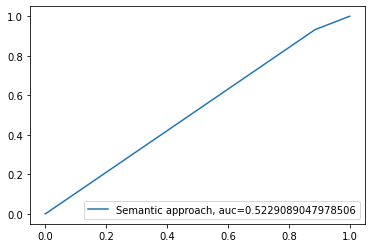

In [34]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  sim_test_pred)
auc = metrics.roc_auc_score(Y_test, sim_test_pred)
plt.plot(fpr,tpr,label="Semantic approach, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## USing MLP Regressor in word embedding for the classification of spoilers

In [35]:
# transform the trainng and development data
processed_train = transform(x_train)
processed_test  = transform(x_test)

In [36]:
# multilayer perceptron clssifier 
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier( max_iter=80,hidden_layer_sizes=(400,400,400)).fit(processed_train,Y_train) # y - gold_label of df_train

test_pred_processed = clf.predict(processed_test)
print(classification_report(test_pred_processed,Y_test)) 

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.56      0.63      0.60      5320
           1       0.68      0.61      0.64      6680

    accuracy                           0.62     12000
   macro avg       0.62      0.62      0.62     12000
weighted avg       0.63      0.62      0.62     12000



In [37]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, test_pred_processed))

0.6200361944695796
